In [185]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Descente de gradient stochastique pour un modèle de mélange gaussien

### 1. Simulation

Text(0.5, 0.98, 'Simulation')

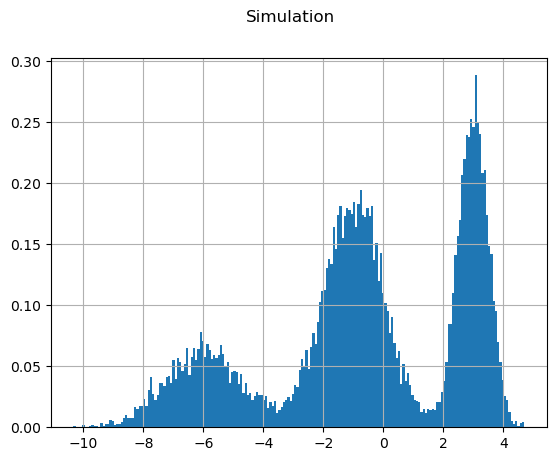

In [189]:
np.random.seed(15)

mu = np.array([-6, -1, 3])
Sig = np.array([1.25, 1., 0.5])
pi = np.array([3000/15000, 7000/15000, 5000/15000])

theta = np.concatenate([pi, mu, Sig])


    
X1 = np.random.normal(mu[0], Sig[0], 3000)
X2 = np.random.normal(mu[1], Sig[1], 7000)
X3 = np.random.normal(mu[2], Sig[2], 5000)

X = np.concatenate([X1, X2, X3])
np.random.shuffle(X)
X = X.reshape(-1, 1)
plt.hist(X, bins=200, density=True)
plt.grid()
plt.suptitle("Simulation")

### 2. Calcul de la log-vraisemblance et du gradient pour l'optimisation numérique 

Modèle de mélange gaussien :

$$
\begin{cases}
    Y_{i}|Z_{i}=k \sim \mathcal{N}(\mu_{k}, \sigma_{k}^2) \\
    Z_{i} \sim \mathcal{M}(1, \pi)
\end{cases}
$$

Paramètre à estimer : 

$$
\theta = (\pi, \mu, \sigma^2)
$$

Densité marginale : soit $f$ la densité de $(Y, Z)$ paramétrée par $\theta$, L la vraisemblance du paramètre $\theta$ pour les données $y$ et $z$. On veut estimer la densité marginale de Y en maximisant la vraisemblance :

$$
p_Y(y;\theta) = \int_z f(y, z;\theta) dz = \sum _ {j = 1} ^ {3} \pi_j \frac{1}{\sqrt{2\pi\sigma_j^2}}e^{-\frac{(y - \mu_j)^2}{2\sigma_j^2}}
$$

$$
\theta ^ * = \mathrm{argmax}_\theta (L(\theta;y,z))
$$

Loi a posteriori des variables latentes :

$$
z_k = p_{Z = k\mid Y } (y, z;\theta) = \frac { p_{Y\mid Z=k}(z, y;\theta) p_{Z=k}(z;\theta)}{ p_Y(y;\theta) } = \frac { \pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(y - \mu_k)^2}{2\sigma_k^2}} } { \sum _ {j = 1} ^ {3} \pi_j \frac{1}{\sqrt{2\pi\sigma_j^2}}e^{-\frac{(y - \mu_j)^2}{2\sigma_j^2}} }
$$

Passage au gradient a posteriori et log-vraisemblance : 

$$
\nabla_\theta \log\, p(y;\theta) = \mathbb{E}[\nabla_\theta \log\, L(\theta; y, z)]
$$

$$
\log\, L(\theta; y_i, z_i) = \sum \limits_{k=1}^{3} z_{ik} \log \, (\pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(y - \mu_k)^2}{2\sigma_k^2}} )
$$

Dérivées partielles de la log vraisemblance :

$$
\nabla_\theta \log\, L(\theta; y_i, z_{i}) =
\begin{cases}
    \frac{\partial}{\partial \pi_k} \log\, L(\theta; y_i, z_{i}) = \frac{z_{ik}}{\pi_k} - 1\\
    \frac{\partial}{\partial \mu_k} \log\, L(\theta; y_i, z_{i}) = z_{ik} \frac{y - \mu_k}{\sigma_k^2}\\
    \frac{\partial}{\partial \sigma_k^2} \log\, L(\theta; y_i, z_{i}) =  z_{ik} ( \frac{(y - \mu_k)^2}{2\sigma_k^4} - \frac{1}{2 \sigma_k^2} )
\end{cases}
$$

**Distribution des a posteriori des variables latentes :**

In [194]:
def pz_y(theta, yi):
    """
    theta = (pi1, pi2, pi3, mu1, mu2, mu3, var1, var2, var3)
    """
    pi = theta[:3]
    mu = theta[3:6]
    sig2 = theta[6:9]

    num = (1/np.sqrt(2*np.pi*sig2)) * np.exp(-(yi - mu)**2/(2*sig2))
    denom = np.sum(pi * (1/np.sqrt(2*np.pi*sig2)) * np.exp(- (yi - mu)**2/(2*sig2)), axis=1)[:,np.newaxis]
    return (pi*num)/denom

**Gradient de la log-vraisemblance :**

In [197]:
def grad(theta, yi, zi) :
    """
    theta = (pi1, pi2, pi3, mu1, mu2, mu3, var1, var2, var3)
    """
    pi = theta[:3]
    mu = theta[3:6]
    sig2 = theta[6:9]

    dpi = (zi/pi) - 1
    dmu = zi*((yi - mu)/sig2)
    dsig2 = zi*( ((yi - mu)**2/ (2* (sig2**2))) - (1 / (2*sig2)) )
    return np.concatenate([dpi, dmu, dsig2], axis=1)

### 3. Initialisation des paramètres

In [241]:
np.random.seed(10)
pi0 = np.random.random(3)
pi0 = pi0/np.sum(pi0)
mu0 = np.array([np.random.uniform(min(X), max(X))[0] for i in range(3)])
sig20 = np.array([np.random.uniform(0.01, (max(X) - min(X))/2)[0] for i in range(3)])
theta0 = np.concatenate([pi0, mu0, sig20])
theta0

array([ 0.54100398,  0.01455541,  0.44444061,  0.9202798 , -2.84120821,
       -6.95455673,  1.49627428,  5.71706294,  1.27901672])

In [243]:
def plot_estimate(theta, y):

    pi = theta[:3]
    mu = theta[3:6]
    sig2 = theta[6:9]
    xx = np.linspace(min(y), max(y), 100)
    
    fig, ax = plt.subplots(1, 1)
    
    ax.grid()
    ax.hist(y, bins=200, density=True, color='blue', label='$y^{(obs)}$')

    y_est = np.sum(pi * (1/np.sqrt(2*np.pi*sig2)) * np.exp(- (xx - mu)**2/(2*sig2)), axis=1)
    ax.plot(xx, y_est, color='red', label='SGD-likelihood estimation')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$p_Y(y)$')
    ax.legend()

In [245]:
def plot_converge(theta_vals):
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    names = ('$\\pi_1$', '$\\pi_2$', '$\\pi_3$', '$\\mu_1$', '$\\mu_2$', '$\\mu_3$', '$\\sigma^2_1$', '$\\sigma^2_2$', '$\\sigma^2_3$')
    for i in range(3):
        for j in range(3):
            k = 3*i + j
            axs[i,j].plot(theta_vals[:,k])
            axs[i,j].grid()
            axs[i,j].set_ylabel(names[k])

### 4. Descente de gradient stochastique classique

In [248]:
def SGD(gamma, yi, theta0, n_iter=1000):

    N = len(yi)
    theta_k = theta0
    vals = [theta0]
    
    for k in range(n_iter):
        
        zi = pz_y(theta_k, yi)
        dtheta_k = grad(theta_k, yi, zi)
        vk = (1/N) * np.sum(dtheta_k, axis=0) 
        theta_k = theta_k + gamma * vk
        vals.append(theta_k)

    return theta_k, np.array(vals)

In [258]:
N = len(X)
K = 3
gamma = 0.05

theta_est, vals = SGD(gamma, X, theta0, 10000)
theta_est

array([ 0.33288987,  0.46599747,  0.20111286,  3.00154553, -0.98299072,
       -5.994702  ,  0.25086519,  1.00702209,  1.62614035])

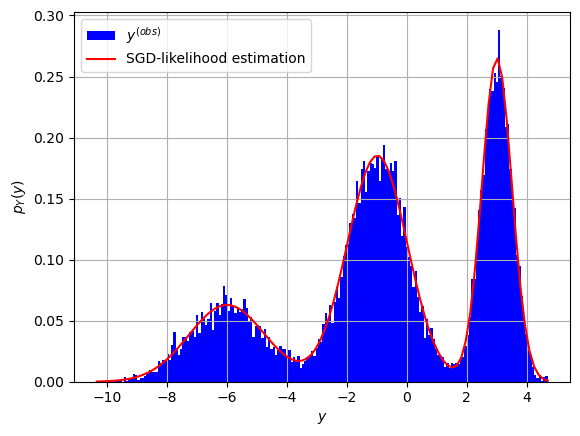

In [260]:
plot_estimate(theta_est, X)
plt.savefig('SGD_lik_est.png')

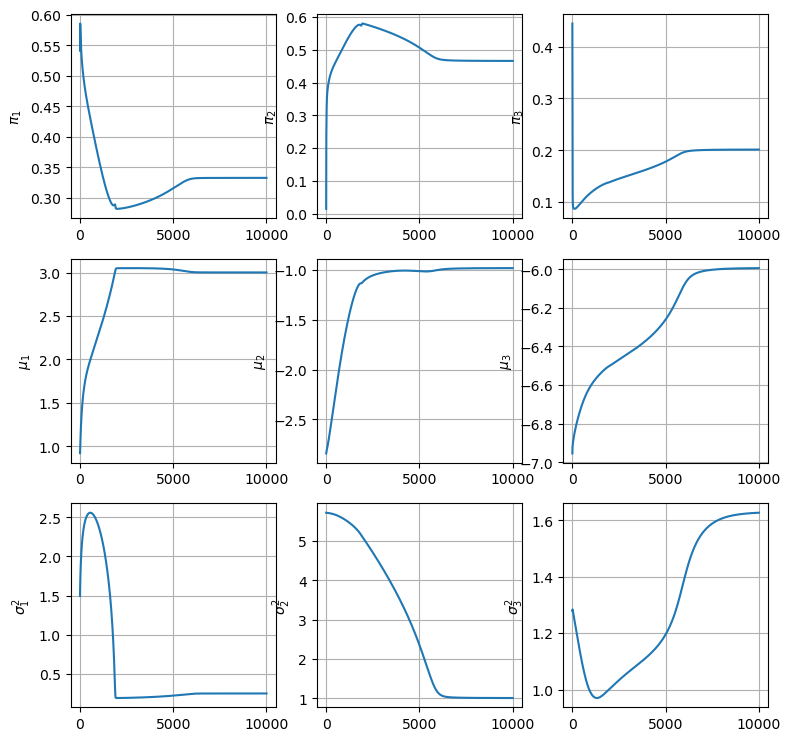

In [262]:
plot_converge(vals)

 ### Heating (à revoir)

In [85]:
def SGDheating(yi, theta0, n_iter, gamma0=1e-4, Kph=1000, alpha=2/3):

    N = len(yi)
    theta_k = theta0
    vals = [theta0]
    grad_norm = []

    Kh = None
    heating_period = True
    
    for k in range(n_iter):

        # estimation a posteriori
        zi = pz_y(theta_k, yi)

        # etape de gradient
        dtheta_k = grad(theta_k, yi, zi)
        vk = (1/N) * np.sum(dtheta_k, axis=0) 
        
        # heating
        if k <= Kph : gamma_k = np.exp((1 - k/Kph)*np.log(gamma0))
        elif heating_period : gamma_k = 1
        else : gamma_k = (k - Kh)**(-alpha)
        
        #mise à jour du heating
        gnmean = np.mean(grad_norm)
        grad_norm.append(np.linalg.norm(vk))
        
        if k > Kph and heating_period :
            if abs(np.mean(grad_norm) - gnmean) < 1e-3 :
                heating_period = False
                Kh = k

        # mise à jour du paramètre theta
        theta_k = theta_k + gamma_k * vk
        vals.append(theta_k)

    return theta_k, vals

In [87]:
theta_est_heat, theta_vals_heat = SGDheating(X, theta0, 1000)

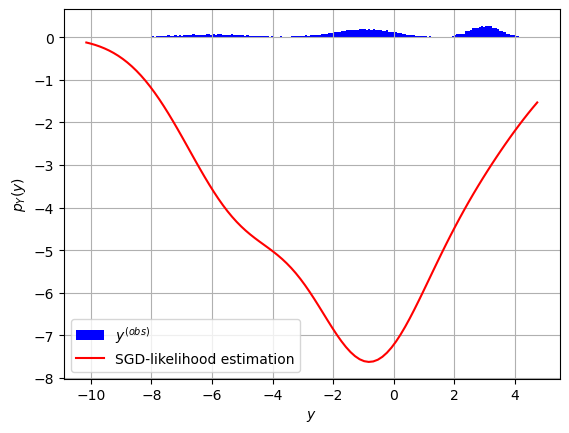

In [89]:
plot_estimate(theta_est_heat, X)
plt.savefig('SGD_lik_est_heat.png')